In [2]:
%load_ext autoreload
%autoreload 2

from diffusers import DDPMPipeline
import torch

model_id = "google/ddpm-cat-256"
device = torch.device("cuda")

pipe = DDPMPipeline.from_pretrained(model_id).to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from diffusers import DDIMScheduler

gen = torch.Generator(device)
gen.manual_seed(3)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

images = pipe(num_inference_steps=100, batch_size=1, generator=gen)

  0%|          | 0/100 [00:00<?, ?it/s]

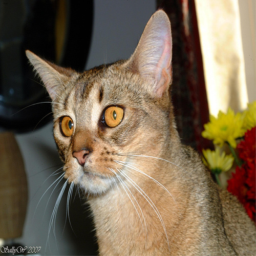

In [4]:
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.functional as TF

transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# Load dataset
dataset = OxfordIIITPet(
    root="data",
    split="trainval",
    target_types="category",
    download=True,
    transform=transform,
)

im, lbl = dataset[8]
TF.to_pil_image(im)

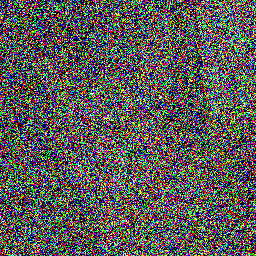

In [19]:
import numpy as np
from PIL import Image

from ipython_utils import to_pil_image


t = torch.Tensor([500]).long()

noisy = pipe.scheduler.add_noise(im, torch.randn_like(im), t)


to_pil_image(noisy, clip=True)


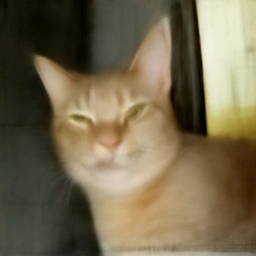

In [20]:
timestep = t.to(device)
sample = noisy.unsqueeze(0).to(device)

with torch.no_grad():
    model_out = pipe.unet(sample, timestep).sample


model_out = pipe.scheduler.step(model_out.cpu(), t.cpu(), sample.cpu())
original_sample = model_out.pred_original_sample

to_pil_image(original_sample[0], clip=True)